In [23]:
# Standard Libraries
import numpy as np
import matplotlib.pyplot as plt

# Third-Party Libraries
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from wordcloud import WordCloud
from textblob import TextBlob
import random

# Optional: If using NLTK for text processing, only import necessary functions
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


In [2]:
df = pd.read_csv('/home/varun/Desktop/Mental Health Project/data/sentientalData.csv')

In [3]:
df.head()

Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety

In [7]:
# Dataset Information and Basic Exploration
print("Dataset Info:")
df.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [6]:
# Descriptive Statistics
print("\nDescriptive Statistics (numerical columns only):")
df.describe() 


Descriptive Statistics (numerical columns only):


Unnamed: 0
count  53043.000000
mean   26521.000000
std    15312.339501
min        0.000000
25%    13260.500000
50%    26521.000000
75%    39781.500000
max    53042.000000

In [8]:
# Checking for missing values
print("\nMissing Values in Each Column:")
df.isnull().sum()


Missing Values in Each Column:


Unnamed: 0      0
statement     362
status          0
dtype: int64

In [9]:
# Checking for duplicated rows
print("\nNumber of Duplicated Rows:")
df.duplicated().sum()


Number of Duplicated Rows:


np.int64(0)

In [10]:
# Displaying column data types
print("\nColumn Data Types:")
df.dtypes


Column Data Types:


Unnamed: 0     int64
statement     object
status        object
dtype: object

In [11]:
print("\nUnique Values in Categorical Columns:")
for col in df.select_dtypes(include=['object']).columns:
    print(f"{col}: {df[col].nunique()} unique values")


Unique Values in Categorical Columns:
statement: 51073 unique values
status: 7 unique values


In [ ]:
# Create a histogram for the distribution of the 'status' column
fig = px.histogram(
    df, 
    x='status', 
    title='Distribution of Mental Health Status', 
    color='status',  # Color bars by 'status' for better distinction
    color_discrete_map={'status': ['#636EFA', '#00CC96', '#FF6347']},  # Custom color palette
    labels={'status': 'Mental Health Status'},  # Customize axis label
    category_orders={'status': sorted(df['status'].unique())}  # Ensure categories are ordered
)

# Customize layout for better readability
fig.update_layout(
    template='plotly_dark',  # Change template to dark mode for better contrast
    xaxis_title='Mental Health Status',  # Title for x-axis
    yaxis_title='Count',  # Title for y-axis
    font=dict(size=14),  # Adjust font size for better visibility
    title_font=dict(size=20, family='Arial', color='white'),  # Title font customization
    bargap=0.2,  # Reduce the gap between bars
    plot_bgcolor='black',  # Set background to black
    showlegend=False  # Hide legend to avoid redundancy in simple cases
)

# Show the plot
fig.show()


In [14]:
# Handle NaN values in the 'statement' column by filling with an empty string or placeholder
df['statement'] = df['statement'].fillna('')  # Fill NaN with an empty string

print(f"Missing values in 'statement' column after filling: {df['statement'].isnull().sum()}")


Missing values in 'statement' column after filling: 0


In [16]:
# Add a new column 'text_length' which holds the number of words in each 'statement'
df['text_length'] = df['statement'].apply(lambda x: len(str(x).split()))

# Create the histogram for text length distribution
fig = px.histogram(
    df, 
    x='text_length', 
    title='Text Length Distribution (Number of Words)', 
    nbins=30,  # Adjust the number of bins for clearer distribution
    labels={'text_length': 'Number of Words'},  # X-axis label
    color_discrete_sequence=['#636EFA'],  # Set color for bars
)

# Customize the layout for a better appearance
fig.update_layout(
    template='plotly_dark',  # Dark mode template for contrast
    xaxis_title='Text Length (Words)',  # Title for x-axis
    yaxis_title='Frequency',  # Title for y-axis
    font=dict(size=14),  # Font size for labels
    title_font=dict(size=20, family='Arial', color='white'),  # Title customization
    bargap=0.2,  # Space between bars
    plot_bgcolor='black',  # Set background to black
    showlegend=False  # Hide legend (as it's not needed here)
)

# Optionally, use log scale if the distribution is highly skewed
# fig.update_xaxes(type="log")  # Uncomment if using log scale

# Show the plot
fig.show()


In [19]:
import nltk

# Download necessary resources for tokenization
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /home/varun/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/varun/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/varun/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [21]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [22]:
# Initialize the lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Preprocessing function
def preprocess_text(text):
    if not isinstance(text, str):  # Check if text is a string
        return ''
    
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\n', '', text)  # Remove newlines
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    
    # Tokenization and stopword removal
    tokens = word_tokenize(text)  # Tokenize text
    tokens = [token for token in tokens if token not in stop_words]  # Remove stopwords
    
    # Lemmatization: Convert words to their base form
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Reassemble text from tokens
    cleaned_text = ' '.join(tokens)
    return cleaned_text

# Apply preprocessing to the 'statement' column
df['cleaned_statement'] = df['statement'].apply(lambda x: preprocess_text(x))

# Display the first few rows to see the effect
print(df[['statement', 'cleaned_statement']].head())


                                           statement  \
0                                         oh my gosh   
1  trouble sleeping, confused mind, restless hear...   
2  All wrong, back off dear, forward doubt. Stay ...   
3  I've shifted my focus to something else but I'...   
4  I'm restless and restless, it's been a month n...   

                                   cleaned_statement  
0                                            oh gosh  
1  trouble sleeping confused mind restless heart ...  
2  wrong back dear forward doubt stay restless re...  
3  ive shifted focus something else im still worried  
4                im restless restless month boy mean  


In [26]:
# Data Augmentation
def augment_text(text):
    try:
        blob = TextBlob(text)
        translated = blob.translate(to='fr').translate(to='en')
        return str(translated)
    except Exception as e:
        return text

df['augmented_statement'] = df['statement'].apply(augment_text)
augmented_df = df[['statement', 'status']].copy()
augmented_df['statement'] = df['augmented_statement']
df = pd.concat([df, augmented_df])

In [27]:
# Reapply preprocessing on augmented data
df['cleaned_statement'] = df['statement'].apply(lambda x: preprocess_text(x))  # Preprocess text
df['cleaned_statement'] = df['cleaned_statement'].apply(lambda x: remove_stopwords(x))  # Remove stopwords


NameError: name 'remove_stopwords' is not defined

In [28]:
# Ensure no NaN values are left
df['cleaned_statement'] = df['cleaned_statement'].fillna('')

In [29]:
# Splitting the data
X = df['cleaned_statement']
y = df['status']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Vectorization
vectorizer = TfidfVectorizer(max_features=10000)  
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [ ]:
# Model Training with Hyperparameter Tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100]
}

model = LogisticRegression(max_iter=1000)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

# Best Model
best_model = grid_search.best_estimator_

In [ ]:
# Predictions
y_pred = best_model.predict(X_test_tfidf)

In [ ]:
# Evaluation
print("Best Parameters:")
print(grid_search.best_params_)

print("Accuracy Score:")
print(accuracy_score(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))

Best Parameters:
{'C': 100}
Accuracy Score:
0.8759072485625412
Classification Report:
                      precision    recall  f1-score   support

             Anxiety       0.92      0.92      0.92      1562
             Bipolar       0.93      0.91      0.92      1150
          Depression       0.84      0.84      0.84      6182
              Normal       0.94      0.96      0.95      6571
Personality disorder       0.86      0.81      0.83       447
              Stress       0.88      0.86      0.87      1047
            Suicidal       0.79      0.79      0.79      4259

            accuracy                           0.88     21218
           macro avg       0.88      0.87      0.88     21218
        weighted avg       0.88      0.88      0.88     21218



In [27]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm_fig = ff.create_annotated_heatmap(
    z=cm,
    x=list(set(y_test)),
    y=list(set(y_test)),
    annotation_text=cm,
    colorscale='Viridis'
)
cm_fig.update_layout(title='Confusion Matrix')
cm_fig.show()


In [28]:
# Feature Importance
feature_names = vectorizer.get_feature_names_out()
coefs = best_model.coef_
for i, category in enumerate(best_model.classes_):
    top_features = coefs[i].argsort()[-10:]
    top_words = [feature_names[j] for j in top_features]
    top_scores = [coefs[i][j] for j in top_features]
    fig = go.Figure([go.Bar(x=top_words, y=top_scores)])
    fig.update_layout(title=f'Top Features for {category}')
    fig.show()

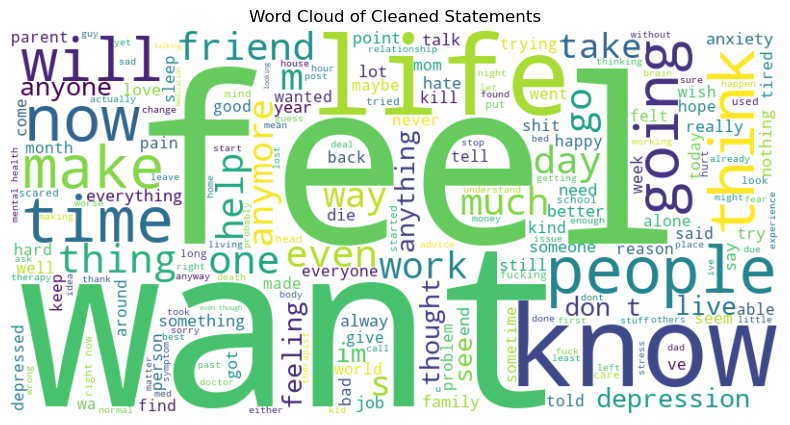

In [29]:
# Word Cloud
all_text = ' '.join(df['cleaned_statement'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Statements')
plt.show()

In [30]:
# Status Distribution
fig = px.pie(df, names='status', title='Proportion of Each Status Category')
fig.show()